# Pathology scoring VCF conversion

In [1]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import matplotlib.projections as pltproject
import pandas as pd
import pickle
import glob
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from collections import Counter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D

In [2]:
import mpmath 
from numba import njit, prange


def generate_constants(i, j, n, W, i_index, j_index):
    
    # k and n are both integers k<n
    Wijn = mpmath.mpf(0)
    Sjn = mpmath.mpf(0)
    Vjn = mpmath.mpf(0)
    
    if i == 1:      
        mid = mpmath.fmul(2*j - 1, 
                                      mpmath.fdiv(mpmath.fmul(mpmath.fac(n),mpmath.fac(n-1)),
                                      mpmath.fmul(mpmath.fac(n+j-1),mpmath.fac(n-j))))
        
        Vjn = mpmath.fmul(mid, 1 + (-1)**j)
        
        Sjn = mpmath.fmul(mid, (-1)**j)

        if j == 2:
            Wijn = mpmath.fdiv(6,n+1)
        
        elif j ==3:
            Wijn = mpmath.fdiv( 30*(n-2*i), (n+1)*(n+2) )
        
        else:
            Wijn = mpmath.fsub(mpmath.fmul(mpmath.fdiv((2*j-1)*(n-2*i),
                                                       (j-2)*(n+j-1)),
                                          W[i_index, j_index-1]),
                              mpmath.fmul(mpmath.fdiv((j-1)*(2*j-1)*(n-j+2), 
                                                     (j-2)*(2*j-5)*(n+j-1)),
                                         W[i_index, j_index-2]))
        return Sjn, Vjn, Wijn
    
    else:
        if j == 2:
            Wijn = mpmath.fdiv(6,n+1)
        
        elif j ==3:
            Wijn = mpmath.fdiv( 30*(n-2*i), (n+1)*(n+2) )
       
        else:
            Wijn = mpmath.fsub(mpmath.fmul(mpmath.fdiv((2*j-1)*(n-2*i),
                                                       (j-2)*(n+j-1)),
                                          W[i_index, j_index-1]),
                              mpmath.fmul(mpmath.fdiv((j-1)*(2*j-1)*(n-j+2), 
                                                     (j-2)*(2*j-5)*(n+j-1)),
                                         W[i_index, j_index-2]))
    return Wijn

n=90
W=mpmath.matrix(len(range(1,int(n/2)+1)),n-1)
V=mpmath.matrix(n-1,1)
S=mpmath.matrix(n-1,1)
for mut_index, mut in enumerate(range(1,int(n/2)+1)):
    for level_index, level in enumerate(range(2,n+1)):
        if mut == 1:
            S[level_index,0], V[level_index,0], W[mut_index, level_index] = generate_constants(mut, level, n, W, mut_index, level_index)
        else:
            W[mut_index, level_index] = generate_constants(mut, level, n, W, mut_index, level_index)


mpmath.mp.dps = 1000

def ej_normal_prime1(j, time):
    
    # j is an integer and W is measured in coalescent times
    binom_j = mpmath.binomial(j,2)
    ej_normal = mpmath.fadd(0, mpmath.exp(-mpmath.fmul(binom_j , time)))
    
    return ej_normal

def ej_normal_prime2(j, time):
    
    # j is an integer and W is measured in coalescent times
    binom_j = mpmath.binomial(j,2)
    ej_normal = mpmath.fmul(mpmath.fsub(0, mpmath.exp(-mpmath.fmul(binom_j , time))),binom_j)
    
    return ej_normal

def ej_normal(j, time):
    
    # j is an integer and W is measured in coalescent times
    binom_j = mpmath.binomial(j,2)
    ej_normal = mpmath.fdiv(mpmath.fsub(1, mpmath.exp(-mpmath.fmul(binom_j , time))), binom_j)
    
    return ej_normal

def generate_lengths_derv(times, disc_muts, S, W):
    
    mp2 = mpmath.mp.clone()
    mp2.dps = 200
    lengths = mp2.matrix(len(times),len(disc_muts))
    lengths_prime1 = mp2.matrix(len(times),len(disc_muts))
    lengths_prime2 = mp2.matrix(len(times),len(disc_muts))

    for time_index, time in enumerate(times):

        ejs_normal = mpmath.matrix(n-1,1)
        ejs_normal_prime1 = mpmath.matrix(n-1,1)
        ejs_normal_prime2 = mpmath.matrix(n-1,1)
        for level_index, level in enumerate(range(2,n+1)):
            ejs_normal[level_index,0] = ej_normal(level, time)
            ejs_normal_prime1[level_index,0] = ej_normal_prime1(level, time)
            ejs_normal_prime2[level_index,0] = ej_normal_prime2(level, time)

        for carrier_index, carrier in enumerate(disc_muts):

            mut = int(carrier*n)

            L = mpmath.mpf(0)
            L_prime1 = mpmath.mpf(0)
            L_prime2 = mpmath.mpf(0)
            
            if mut<int(n/2)+1:

                mut_index = list(range(1,int(n/2)+1)).index(mut)
                for level_index, level in enumerate(range(2,n+1)):
                    
                    L = L+ejs_normal[level_index, 0]*W[mut_index, level_index] 
                    L_prime1 = L_prime1+ejs_normal_prime1[level_index, 0]*W[mut_index, level_index] 
                    L_prime2 = L_prime2+ejs_normal_prime2[level_index, 0]*W[mut_index, level_index] 

            elif mut<n:
                mut_index = list(range(1,int(n/2)+1)).index(n-mut)

                for level_index, level in enumerate(range(2,n+1)):
                    
                    L = L+(-1)**(level)*ejs_normal[level_index, 0]*W[mut_index, level_index]
                    L_prime1 = L_prime1+(-1)**(level)*ejs_normal_prime1[level_index, 0]*W[mut_index, level_index] 
                    L_prime2 = L_prime2+(-1)**(level)*ejs_normal_prime2[level_index, 0]*W[mut_index, level_index] 

            else:

                L = time
                L_prime1 = 1
                L_prime2 = 0

                for level_index, level in enumerate(range(2,n+1)):
                    
                    L = L-ejs_normal[level_index, 0]*S[level_index, 0]
                    L_prime1 = L_prime1-ejs_normal_prime1[level_index, 0]*S[level_index, 0]
                    L_prime2 = L_prime2-ejs_normal_prime2[level_index, 0]*S[level_index, 0]
                    
            lengths[time_index, carrier_index] = mp2.mpf(L)
            
            lengths_prime1[time_index, carrier_index] = mp2.mpf(L_prime1)
            
            lengths_prime2[time_index, carrier_index] = mp2.mpf(L_prime2)
    
    return lengths, lengths_prime1, lengths_prime2


In [3]:
@njit(parallel=True)
def makethetaDiffs(times, thetas):

    diffs = np.diff(thetas)
    diffs = np.append(diffs,diffs[-1])
    bigDiffs = np.zeros((len(times), len(thetas)))
    for time_index, time in enumerate(times):
        bigDiffs[time_index, :] = diffs
    return bigDiffs

from bisect import bisect_left

@njit(parallel=True)
def logPopPriorAlphas(alphas, tau_alphas, times):
    # Makes the log priors for a given hyperprior value of alpha, tau_alpha and age of donor
    
    logPopPriorAlpha = np.zeros((alphas.shape[0], tau_alphas.shape[0], times.shape[0]))
    for alpha_index, alpha in enumerate(alphas):
            for tau_alpha_index, tau_alpha in enumerate(tau_alphas):
                logPopPriorAlpha[alpha_index, tau_alpha_index, :] = np.log(1/(times*tau_alpha*np.sqrt(2*np.pi))) -(np.log(times)-np.log(alpha))**2/(2*tau_alpha**2)
    return logPopPriorAlpha

@njit(parallel=True)
def logPopPriorThetas(nus, tau_nus, thetas):
    # Makes the log priors for a given hyperprior value of nu, tau_nu and number of bases 
    
    logPopPriorTheta = np.zeros((nus.shape[0], tau_nus.shape[0], thetas.shape[0]))
    for nu_index, nu in enumerate(nus):
            for tau_nu_index, tau_nu in enumerate(tau_nus):
                logPopPriorTheta[nu_index, tau_nu_index, :] = np.log(1/(thetas*tau_nu*np.sqrt(2*np.pi))) - (np.log(thetas)-np.log(nu))**2/(2*tau_nu**2)
    return logPopPriorTheta

def hyperPriorDiff(hyperPriors, nus):
    diffs = np.diff(nus)
    diffs = np.append(diffs,diffs[-1])
    bigDiffs = np.tile(diffs, (hyperPriors.shape[0], hyperPriors.shape[2], hyperPriors.shape[3], 1))
    bigDiffs = np.swapaxes(np.swapaxes(bigDiffs, 2,3), 1,2)
    hyperPriors = bigDiffs* hyperPriors
    return hyperPriors

def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before

def hyperDiff(hyperPriors, nus):
    diffs = np.diff(nus)
    diffs = np.append(diffs,diffs[-1])
    bigDiffs = np.tile(diffs, (hyperPriors.shape[0], hyperPriors.shape[2], hyperPriors.shape[3], 1))
    bigDiffs = np.swapaxes(np.swapaxes(bigDiffs, 2,3), 1,2)
    hyperPriors = bigDiffs* hyperPriors
    return hyperPriors

In [4]:
md = pd.read_pickle("../../data/precomputedData/full_human_metadata.pkl")
md = md.sort_values(by = ['donor_age'])
ages = md['donor_age'].drop_duplicates()

# Run from here if initial compilation is done

In [ ]:
d_donor_mur = pd.read_pickle('../../data/precomputedData/Muraro/muraroVariantsSTAR200V1.pkl')
d_donor_eng = pd.read_pickle('../../data/precomputedData/Enge/engeVariantsSTAR200.pkl')
d_donor_voi = pd.read_pickle('../../data/precomputedData/Voigt/voigtVariantsSTAR200V1.pkl')

# Code to concat all the datasets into the same dataframe
d_donor_voi['dataset'] = 'voi'
d_donor_mur['dataset'] = 'mur'
d_donor_eng['dataset'] = 'eng'

d_donor_voi['donor_age'] = d_donor_voi.donor_id
d_donor_mur['donor_age'] = d_donor_mur.donor_id
d_donor_eng['donor_age'] = d_donor_eng.donor_id

d_donor_mur['donor_id'] = d_donor_mur['donor_id'].astype(str) + '-Mur'
d_donor_eng['donor_id'] = d_donor_eng['donor_id'].astype(str) + '-Eng'
d_donor_voi['donor_id'] = d_donor_voi['donor_id'].astype(str) + '-Voi'
d_donor_eng['SRR'] = d_donor_eng['sample_id']
d_donor_all = pd.concat([d_donor_mur,d_donor_eng,d_donor_voi], ignore_index=False, sort = False)

d_donor_all = d_donor_all.sort_values(by = ['donor_age','donor_id'])

with open('../../data/precomputedData/human_baseDict.pkl', 'rb') as handle:
    bases = pickle.load(handle)
with open('../../data/precomputedData/human_cellDict.pkl', 'rb') as handle:
    cells = pickle.load(handle)

donors = d_donor_all.donor_id.unique()

eng_colour = (0.00392156862745098, 0.45098039215686275, 0.6980392156862745)
mur_colour = (0.8705882352941177, 0.5607843137254902, 0.0196078431372549)
voi_colour = (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)

namedict={'Eng':'Enge',
 'Mur':'Muraro',
 'Voi':'Voigt'}

# Looking at bulk heteroplasmy and detectable mutants
Figure 1d

In [6]:
d_donor_all['bulk'] = d_donor_all['mean_HF']*d_donor_all['mutant_sequenced_prop']

nohaps=d_donor_all.drop_duplicates(subset=['donor_id','POS','ALT'])
nohaps=nohaps[nohaps.mutant_type !='Common mutation']
nohaps=nohaps[~((nohaps.mean_HF>0.95)&(nohaps.mutant_sequenced_prop>0.95))]

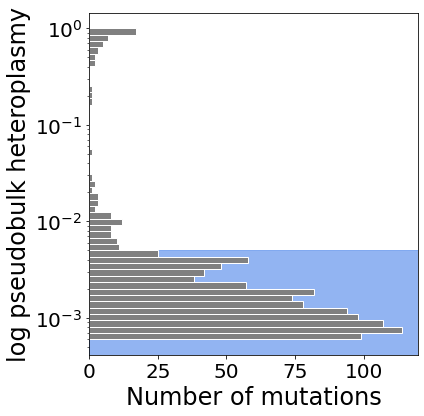

In [7]:
bin_arr= np.logspace(np.log10(0.0006),np.log10(1), 50)
plt.figure(figsize=(6,6))
plt.axhspan(5e-03,0, alpha=0.7,color='cornflowerblue',zorder=1)
h, bins, patches = plt.hist(nohaps[((nohaps.mean_HF>0.1)&(nohaps.dataset=='eng')&(nohaps.cells_possible >10))].drop_duplicates(subset=['donor_id','POS','ALT']).bulk,#density=True,
                            bins=bin_arr,orientation='horizontal',color='white', alpha=0.5,zorder=2)
i=0
for p, b in zip(patches, bins):

    p.set_color('grey')
    p.set_alpha(1)
    p.set_edgecolor('white')

plt.yscale('log')
plt.ylabel('log pseudobulk heteroplasmy',size=24)
plt.xlabel('Number of mutations',size =24)
plt.tick_params(axis='both',  labelsize=20)

plt.tight_layout()
plt.savefig('../../figures/publicationFigures/figure1d.pdf')
plt.show()

# Difference between SFSs
Figure 1e

In [8]:
bin_num=20
bin_arr = [q/bin_num for q in range(int(0.05*bin_num),bin_num+1)]
filt = d_donor_all[((d_donor_all.mutant_type == 'Cryptic')&(d_donor_all.cells_possible>10))]
filt = filt[filt['HF'] >=0.1]
age_dist={}
for age in d_donor_all.donor_id.unique():
    age_dist[age] = filt.loc[filt.donor_id == age].HF

# Make arrays of RBC-difference between every pair of distributions
stat = []
for age in filt.donor_id.unique():
    stat_temp = []
    for age1 in filt.donor_id.unique():
        stat_temp.append(1-2*stats.mannwhitneyu(age_dist[age],age_dist[age1],alternative='greater')[0]/(len(age_dist[age1])*len(age_dist[age])))
    stat.append(stat_temp)

statdf = pd.DataFrame((np.array(stat)),index = filt.donor_id.unique(), columns=filt.donor_id.unique())
x = np.triu(np.ones(statdf.shape))
np.fill_diagonal(x,0)
statdf = statdf.where(x.astype(np.bool))
statdf = statdf.stack().reset_index()
statdf.columns = ['Row','Column','Value']

age_diff = []
for age in filt.drop_duplicates(subset=['donor_id'])['donor_age']:
    po = []
    for age2 in filt.drop_duplicates(subset=['donor_id'])['donor_age']:
        po.append((age2-age))
    age_diff.append(po)

pddiff = pd.DataFrame(age_diff)
x = np.triu(np.ones(pddiff.shape))
np.fill_diagonal(x,0)
pddiff = pddiff.where(x.astype(np.bool))
pddiff = pddiff.stack().reset_index()
pddiff.columns = ['Row','Column','Value']

# Make an array labelling if the pair is within dataset or across dataset
data_diff = []
for data in filt.drop_duplicates(subset=['donor_id'])['dataset']:
    do = []
    for data1 in filt.drop_duplicates(subset=['donor_id'])['dataset']:
        if data == data1:
            do.append(data)
        else:
            do.append('mixed')
    data_diff.append(do)

datadiff = pd.DataFrame(data_diff)
x = np.triu(np.ones(datadiff.shape))
np.fill_diagonal(x,0)
datadiff = datadiff.where(x.astype(np.bool))
datadiff = datadiff.stack().reset_index()
datadiff.columns = ['Row','Column','Value']
datadiff['Dataset'] = datadiff['Value'].map({'eng':'Pancreas 1','mur':'Pancreas 2','voi':'Eye','mixed':'Mixed'})

Spearman Rank Correlation=0.705
 p=5.743e-27


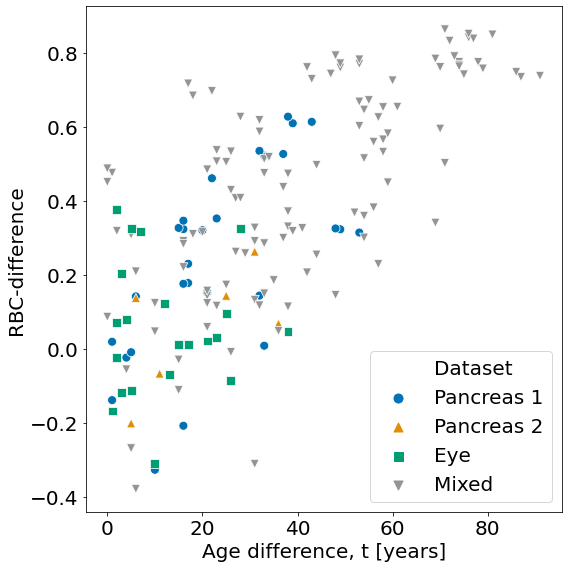

In [9]:
fig = plt.figure(figsize=(8,8))
sns.set_palette([(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451)])
markers = ['o','^','s','v']
sns.scatterplot(pddiff['Value'],statdf['Value'], hue=datadiff['Dataset'], hue_order=['Pancreas 1','Pancreas 2','Eye','Mixed'],
                style=datadiff['Dataset'],style_order=['Pancreas 1','Pancreas 2','Eye','Mixed'],markers=markers,s=80);

plt.xlabel('Age difference, t [years]', size = 20)
plt.ylabel('RBC-difference', size = 20)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(loc='lower right',fontsize=20, markerscale=1.5)
foo = stats.spearmanr(pddiff['Value'],statdf['Value'])
print('Spearman Rank Correlation={0:.3f}\n p={1:.3e}'.format(foo[0],foo[1]))
plt.tight_layout()
plt.savefig('../../figures/publicationFigures/figure1e.pdf')
plt.show()

<ipython-input-10-04ee2eb590df>:1: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)


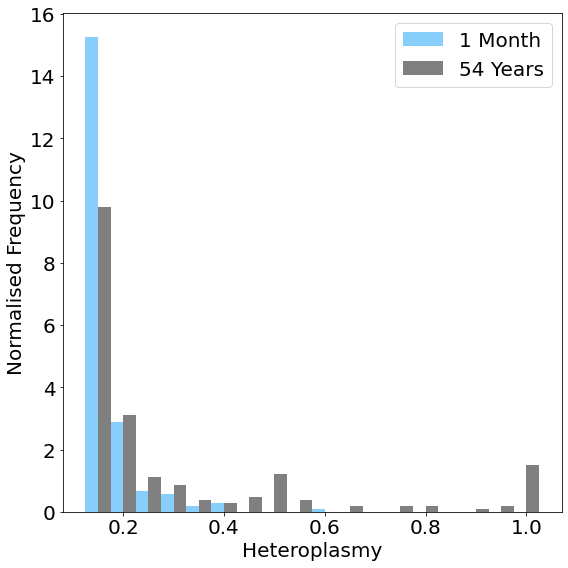

In [10]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)

fig, ax1 = plt.subplots( figsize=(8, 8))

# Code to get all the data to  plot
bin_arr = [q/20 for q in range(2,21)]
offsets= [0.05/2,0]
colours=['#87cefaff','#808080ff']
classes=['1-Eng','54-Eng']
class_map={'1-Eng': '1 Month','54-Eng':'54 Years'}
bars = pd.DataFrame()


# Filters for the mutant type, dataset and heteroplasmy range we are interested in
filt = d_donor_all[((d_donor_all.mutant_type == 'Cryptic')&(d_donor_all.cells_possible>10))]
filt = filt[filt['HF'] >=0.1]

# Looks at the class you are interested in, splits up mean heteroplasmy into bins and then counts the number in each bin and normalises
age_dist = {}
for pathology in classes:
    age_dist[pathology] = filt.loc[filt.donor_id == pathology].mean_HF
    group = age_dist[pathology].groupby([pd.cut(age_dist[pathology], bin_arr, include_lowest=True)])
    bars[pathology] = group.count()
    bars[pathology] = bars[pathology]/(bars[pathology].sum()*0.05)


# Start of Plotting Section:

for i,  age in enumerate(classes):
    ax1.bar(np.array(bin_arr[1:])-offsets[i],bars[age].values,width=0.05/2,align='edge',color=colours[i],label=class_map[age])

plt.legend(prop={'size': 20})
plt.xlabel('Heteroplasmy', size = 20)
plt.ylabel('Normalised Frequency', size = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()
plt.savefig('../../figures/publicationFigures/figure1f.pdf')
plt.show()

# Plot the regression of age against inferred coalescent age
figure 1h

In [11]:
with open(f'../../data/posteriors/human/mutationHyperMarg.pkl', 'rb') as handle:
    nu_Marg = pickle.load(handle)

with open(f'../../data/posteriors/human/alphaHyperMarg.pkl', 'rb') as handle:
    alpha_Marg = pickle.load(handle)
    
with open(f'../../data/posteriors/human/nus_range.pkl', 'rb') as handle:
    nus = pickle.load(handle)
    
with open(f'../../data/posteriors/human/tau_nus_range.pkl', 'rb') as handle:
    tau_nus = pickle.load(handle)
    
with open(f'../../data/posteriors/human/alphas_range.pkl', 'rb') as handle:
    alphas = pickle.load(handle)
    
with open(f'../../data/posteriors/human/tau_alphas_range.pkl', 'rb') as handle:
    tau_alphas = pickle.load(handle)
    
mut, alpha = nus[nu_Marg.argmax()], alphas[alpha_Marg.argmax()]

In [12]:
cdict={'Enge':(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 'Muraro':(0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 'Voigt':(0.00784313725490196, 0.6196078431372549, 0.45098039215686275)}
namedict={'Eng':'Enge',
 'Mur':'Muraro',
 'Voi':'Voigt'}
styledict={'Enge':'o',
'Muraro':'^',
'Voigt':'s'}

with open(f'../coalescentInfer/times.pkl', 'rb') as handle:
    times = pickle.load(handle)
with open(f'../coalescentInfer/thetas.pkl', 'rb') as handle:
    thetas = pickle.load(handle)
    
thetaDiffs = makethetaDiffs(times, thetas)

donorMarg={}
for donor in donors:
    with open(f'../../data/posteriors/human/posteriorMarg_{donor}.pkl', 'rb') as handle:
        donorMarg[donor] = pickle.load(handle)

norm = {}
time_marg = {}
for donor in donors:
    thetaDiffs = makethetaDiffs(times, thetas)
    norm[donor] = (donorMarg[donor]*thetaDiffs).sum()
    time_marg[donor] =(donorMarg[donor]*thetaDiffs).sum(axis=1)/norm[donor]

In [13]:
max_times = []
min_time_errors = []
max_time_errors = []
ages = []
data = []
for donor_id in donors:
    max_times.append(times[time_marg[donor_id].argmax()])
    min_time_errors.append(max_times[-1] -np.nanmin(np.where((np.cumsum(time_marg[donor_id].astype(float))>0.05) & ( np.cumsum(time_marg[donor_id].astype(float))<0.95), times,np.nan)))
    max_time_errors.append(np.nanmax(np.where((np.cumsum(time_marg[donor_id].astype(float))>0.05) & ( np.cumsum(time_marg[donor_id].astype(float))<0.95), times,np.nan))-max_times[-1])
    ages.append(int(donor_id[:-4]))
    data.append(namedict[donor_id[-3:]])

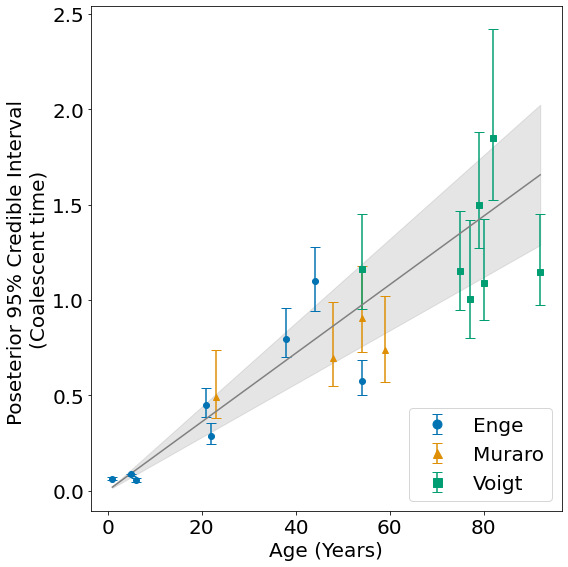

In [14]:
fig = plt.figure(figsize=(8,8))
for g in np.unique(np.array(data)):
    ix = np.where(np.array(data) == g)
    plt.errorbar(np.array(ages)[ix], np.array(max_times)[ix]/2, yerr= np.array([np.array(min_time_errors)[ix].T/2 ,np.array(max_time_errors)[ix].T/2]), c = cdict[g], capsize=5,label = g, fmt = styledict[g])
plt.xlabel('Age (Years)', size=20)
plt.ylabel('Poseterior 95% Credible Interval \n(Coalescent time)',size=20)
plt.legend(loc='lower right',fontsize=20, markerscale=1.5)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.plot(ages, alpha*np.array(ages)/2, color='grey')
plt.fill_between(ages, 0.028*np.array(ages)/2, 0.044*np.array(ages)/2, color='grey', alpha = 0.2)
plt.tight_layout()
plt.savefig('../../figures/publicationFigures/figure1h.pdf')
plt.show()

# Plot the marginal on mutation rate for the human data
figure 1i

In [15]:
difer = np.diff(nus)
difer = np.append(difer, difer[-1])

posts_nus_diffs = hyperDiff(posts, nus)
norm_posts = posts_nus_diffs.sum()
nu_Marg = posts.sum(axis=3).sum(axis=2).sum(axis=0)/norm_posts

NameError: name 'posts' is not defined

In [ ]:
alpha_Marg = posts_nus_diffs.sum(axis=3).sum(axis=2).sum(axis=1)/norm_posts

In [ ]:
with open('../../data/posteriors/human/alphaHyperMarg.pkl', 'wb') as handle:
    alpha_Marg = pickle.dump(handle)

In [ ]:
with open('../../data/posteriors/human/mutationHyperMarg.pkl', 'rb') as handle:
    nu_Marg = pickle.load(handle)

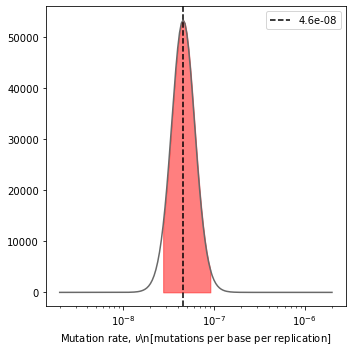

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(nus/500, nu_Marg, c='dimgrey')

plt.axvline(mut/500,  label = f'{mut/500:.2g}', linestyle = '--', c='black')
plt.fill_between(nus/500, nu_Marg,
                 where = (np.cumsum(nu_Marg*difer)>=0.025) & (np.cumsum(nu_Marg*difer)<=0.975), 
                 color='red', alpha = 0.5)

plt.xlabel(r'Mutation rate, $\nu$\n[mutations per base per replication]')
plt.xscale('log')

plt.legend()
plt.tight_layout()
plt.savefig('../../figures/publicationFigures/figure1i.pdf')
plt.show()

# Show the heteroplasmy equilibration line
figure 1j

In [ ]:
n=90
thresh = 1/90
disc_muts = [x/n for x in list(range(int(thresh*n),n+1))]
times = np.linspace(0,120*alpha, num =201)
lengths, lengths_prime1, lengths_prime2 = generate_lengths_derv(times, disc_muts, S, W)

lens = np.array(lengths.tolist(), dtype=float)[1:,:-1]
lens = lens/np.tile(lens.sum(axis=1), (89,1)).T

norm = np.linspace(1,89, 89)
norm = norm
norm = 2/norm
norm = norm/norm.sum()

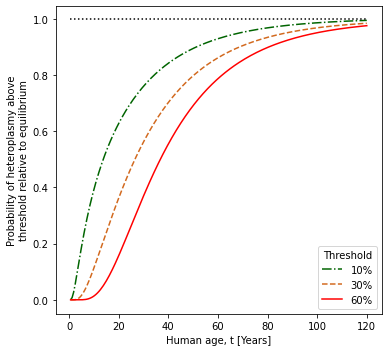

In [ ]:
plt.figure(figsize=(5.5,5))

p_het_10 = []
for i in range(lens.shape[0]):
    p_het_10.append((lens[i][9:].sum())/norm[9:].sum())
    
plt.plot(times[1:]/alpha, p_het_10, label = '10%', linestyle = '-.',  c= 'darkgreen')

p_het_30 = []
for i in range(lens.shape[0]):
    p_het_30.append((lens[i][26:].sum())/norm[26:].sum())
    
plt.plot(times[1:]/alpha, p_het_30, label = '30%', linestyle = '--', c='chocolate')

p_het_60 = []
for i in range(lens.shape[0]):
    p_het_60.append((lens[i][54:].sum())/norm[54:].sum())
    
plt.plot(times[1:]/alpha, p_het_60, label = '60%', c='red')


plt.xlabel('Human age, t [Years]')
plt.axhline(1, xmin=0.045, xmax=0.955,c='black', linestyle = 'dotted')

plt.ylabel('Probability of heteroplasmy above\nthreshold relative to equilibrium')
plt.legend(title= 'Threshold')
plt.tight_layout()
plt.savefig('../../figures/publicationFigures/figure1j.pdf')
plt.show()


# Look at the spread of homoplasmic/high heteroplasmy variants
figure 1k

In [ ]:
n=90
thresh = 0.95
disc_muts = [x/n for x in list(range(int(thresh*n),n+1))]
mut, alpha = nus[np.unravel_index(posts.argmax(), posts.shape)[1]], alphas[np.unravel_index(posts.argmax(), posts.shape)[0]]
times = np.linspace(0,92*alpha, num =100)
lengths, lengths_prime1, lengths_prime2 = generate_lengths_derv(times, disc_muts, S, W)

SpearmanrResult(correlation=0.9066901408450705, pvalue=8.806663852366618e-08)


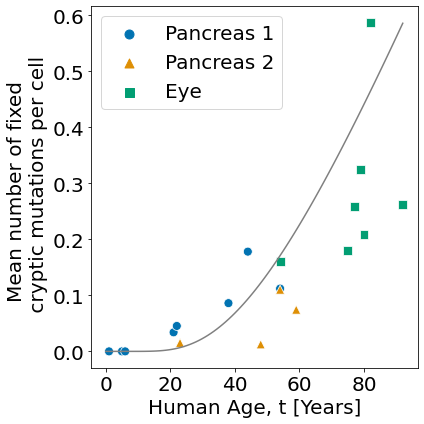

In [ ]:
datamap={'Eng':'Pancreas 1','Mur':'Pancreas 2','Voi':'Eye'}

# Filter so only cryptic homoplasmic mutations are in the dataframe
homo_muts = d_donor_all[((d_donor_all.mutant_type =='Cryptic')&(d_donor_all.cells_possible>10)&(d_donor_all.HF>0.95))]


y=[]
bars={}
dataset=[]

ages = d_donor_all.drop_duplicates(subset=['donor_id'])['donor_age']

# Loop through all donors counting the number of homoplasmies and normalised against the total cells mutations were seen in
# and the average number of bases passing quality control for that donor

for age in d_donor_all.donor_id.unique():
    
    dataset.append(datamap[age[-3:]])
    age_split = homo_muts.loc[homo_muts.donor_id == age]
    bars[age] = len(age_split)/(cells[age]*(bases[age]/16959))
    y.append(bars[age])

plt.figure(figsize=(6,6))
colour = sns.color_palette("colorblind")
markers = ['o','^','s']
sns.scatterplot(ages,y, hue=dataset,style = dataset,style_order=['Pancreas 1','Pancreas 2','Eye'], markers=markers,s=80)
plt.plot(times/alpha, np.array(lengths.tolist(), dtype=float)[:,:].sum(axis=1)*(mut*16569), color = 'grey')
plt.legend(loc='upper left',fontsize=20, markerscale=1.5)
print(stats.spearmanr(ages,y, axis=0
                     ))
plt.xlabel('Human Age, t [Years]', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.ylabel('Mean number of fixed \n cryptic mutations per cell',size=20)
plt.tight_layout()
plt.savefig('../../figures/publicationFigures/figure1k.pdf')
plt.show()

figure 1l

In [ ]:
n=90
thresh = 0.6
disc_muts = [x/n for x in list(range(int(thresh*n),n+1))]
times = np.linspace(0,100*alpha, num =100)
lengths, lengths_prime1, lengths_prime2 = generate_lengths_derv(times, disc_muts, S, W)

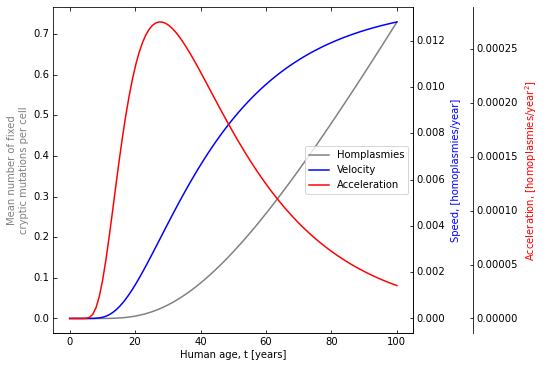

In [ ]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1,1, figsize=(8,6))

axs.set_yticks([])
axs.set_xticks([])
ax1 = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)


ax2 =ax1.twinx()
ax3 =ax1.twinx()

offset = 60
new_fixed_axis = ax3.get_grid_helper().new_fixed_axis

ax2.axis["right"].toggle(all=True)
ax3.axis["right"] = new_fixed_axis(loc="right",
                                    axes=ax3,
                                    offset=(offset, 0))
ax3.axis["right"].toggle(all=True)

ax1.set_xlabel("Human age, t [years]")
ax1.set_ylabel("Mean number of fixed\ncryptic mutations per cell")
ax2.set_ylabel("Speed, [homoplasmies/year]")
ax3.set_ylabel("Acceleration, [homoplasmies/year$^2$]")

p1, = ax1.plot(times/alpha,np.array(lengths.tolist(), dtype=float)[:,-11:].sum(axis=1)*(mut*16569), label='Homplasmies', color='grey')
p2, = ax2.plot(times/alpha,np.array(lengths_prime1.tolist(), dtype=float)[:,-11:].sum(axis=1)*(mut*16569)*alpha, label='Velocity', color='blue')
p3, = ax3.plot(times/alpha,np.array(lengths_prime2.tolist(), dtype=float)[:,-11:].sum(axis=1)*(mut*16569)*alpha**2, label = 'Acceleration', color='red')

ax1.legend(loc = 'center right')
ax1.axis["left"].label.set_color(p1.get_color())
ax2.axis["right"].label.set_color(p2.get_color())
ax3.axis["right"].label.set_color(p3.get_color())

plt.savefig('../../figures/publicationFigures/figure1l.pdf')
plt.show()

figure 1m

<ipython-input-22-255f63a76aa9>:10: RuntimeWarning: invalid value encountered in less
  plt.axvline(times[np.where(thresh90 == thresh90[thresh90<0.3][-1])[0][0]]/alpha, ymin=0, ymax=0.475,c='red', linestyle='--')


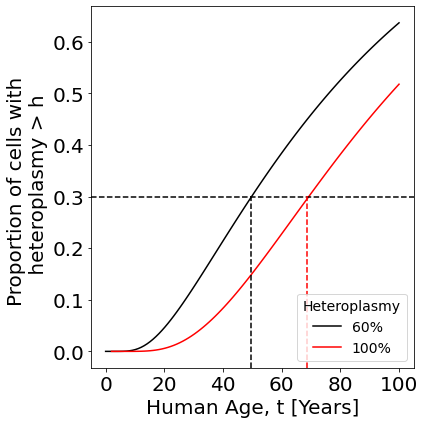

In [ ]:
plt.figure(figsize=(6,6))
thresh60 = 1-stats.poisson.pmf(0, np.array(lengths.tolist(), dtype=float).sum(axis=1)*(mut*16569))
plt.plot(times/alpha, thresh60, 
         color='black', label = '60%')
thresh90 = 1-stats.poisson.pmf(0, np.array(lengths.tolist(), dtype=float)[:,-11:].sum(axis=1)*(mut*16569))
plt.plot(times/alpha, thresh90, 
         color='red', label = '100%')
plt.axhline(0.3, c='black', linestyle='--')
plt.axvline(times[np.where(thresh60 == thresh60[thresh60<0.3][-1])[0][0]]/alpha , ymin=0, ymax=0.475, c='black', linestyle='--')
plt.axvline(times[np.where(thresh90 == thresh90[thresh90<0.3][-1])[0][0]]/alpha, ymin=0, ymax=0.475,c='red', linestyle='--')
plt.xlabel('Human Age, t [Years]', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.ylabel('Proportion of cells with \n heteroplasmy > h',size=20)
plt.legend(title = 'Heteroplasmy',title_fontsize=14, fontsize=14, loc='lower right')
plt.tight_layout()
plt.savefig('../../figures/publicationFigures/figure1m.pdf')
plt.show()

# Pathology and synonymous/non-synoymous selection
figure 2

In [ ]:
import pickle
with open('../../data/precomputedData/human_syn_dict.pkl', 'rb') as handle:
    syndict = pickle.load(handle)
    
synProp = 8178/(25845+8178)
nonSynProp = 25845/(25845+8178)
d_donor_all['MUT'] = d_donor_all['REF']+d_donor_all['POS'].astype(str)+d_donor_all['ALT']
d_donor_all['SYN'] = d_donor_all.MUT.map(syndict)

In [ ]:
bin_arr = [0,0.5,1.0]

nohaps=d_donor_all.drop_duplicates(subset=['donor_id','POS','ALT'])
nohaps=nohaps[nohaps['dataset']=='eng']
nohaps=nohaps[(nohaps.mutant_type!='Common mutation')&(nohaps.mutant_type!='Cryptic')]
nohaps = nohaps[nohaps.HF>0.1]

nonSynAll=(nohaps.groupby(['SYN',pd.cut(nohaps.mean_HF, bin_arr, include_lowest=True)]).count().fillna(0).loc['Non-Synonymous']).DF
synAll=nohaps.groupby(['SYN',pd.cut(nohaps.mean_HF, bin_arr, include_lowest=True)]).count().fillna(0).loc['Synonymous'].DF
print('All',stats.fisher_exact([[synProp*(synAll.sum()+nonSynAll.sum()),synAll.sum()],[nonSynProp*(synAll.sum()+nonSynAll.sum()),nonSynAll.sum()]]))

All (0.28982259570494867, 6.9009212862849804e-09)


In [ ]:
bin_arr = [0,0.5,1.0]

cryps=d_donor_all[((d_donor_all.dataset=='eng')&(d_donor_all.mutant_type=='Cryptic')&(d_donor_all.cells_possible>10))]
cryps=cryps[((cryps.HF>0.1))]

nonSynCryp=(cryps.groupby(['SYN',pd.cut(cryps.mean_HF, bin_arr, include_lowest=True)]).count().fillna(0).loc['Non-Synonymous']).DF
synCryp=cryps.groupby(['SYN',pd.cut(cryps.mean_HF, bin_arr, include_lowest=True)]).count().fillna(0).loc['Synonymous'].DF

print('Cryptics',stats.fisher_exact([[synProp*(synCryp.sum()+nonSynCryp.sum()),synCryp.sum()],[nonSynProp*(synCryp.sum()+nonSynCryp.sum()),nonSynCryp.sum()]]))

Cryptics (1.0648624533592899, 0.5611071153836256)


c:\Users\alist\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
<ipython-input-26-f1c3b525bdcc>:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


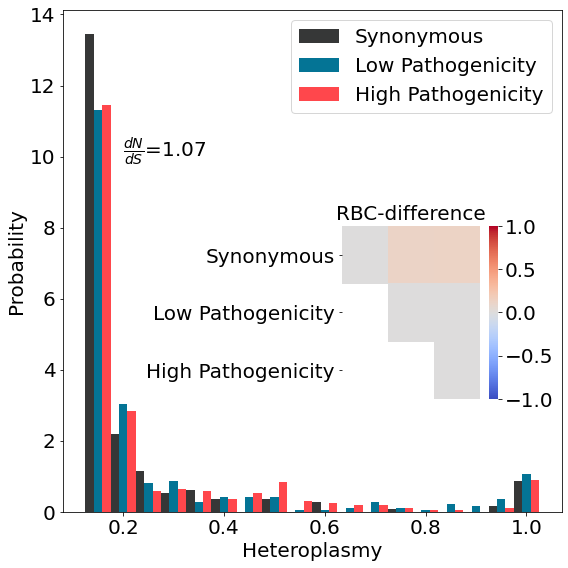

In [ ]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)

fig, ax1 = plt.subplots( figsize=(8, 8))

# Code to get all the data to  plot
bin_arr = [q/20 for q in range(2,21)]
offsets= [0.05/3,0,-0.05/3]
colours=['#363737','#047495','#ff474c']
classes=['Synonymous','Low Pathogenicity','High Pathogenicity']
bars = pd.DataFrame()

# This is just for getting only mutations which are pathology scored.
mas = {'Synonymous':'Synonymous','low_pathogenicity':'Low Pathogenicity','high_pathogenicity':'High Pathogenicity'}
patho_scored = d_donor_all[d_donor_all['MutPred_Probability'] != '.']
patho_scored['MutPred_Prediction'] = patho_scored['MutPred_Prediction'].map(mas)

# Filters for the mutant type, dataset and heteroplasmy range we are interested in
filt = patho_scored[((patho_scored.cells_possible>10)&(patho_scored.dataset=='eng')&(patho_scored.mutant_type == 'Cryptic')&(patho_scored.HF > 0.1))]

# Looks at the class you are interested in, splits up mean heteroplasmy into bins and then counts the number in each bin and normalises
age_dist = {}
for pathology in classes:
    age_dist[pathology] = filt.loc[filt.MutPred_Prediction == pathology].mean_HF
    group = age_dist[pathology].groupby([pd.cut(age_dist[pathology], bin_arr, include_lowest=True)])
    bars[pathology] = group.count()
    bars[pathology] = bars[pathology]/(bars[pathology].sum()*0.05)

# Make dataframe with rank Biserial correlation between each pair of class
stat = []
pvals = []
for pathology in classes:
    kol = []
    ager= []
    for pathology1 in classes:
        kol.append(1-2*stats.mannwhitneyu(age_dist[pathology],age_dist[pathology1],alternative='two-sided')[0]/(len(age_dist[pathology1])*len(age_dist[pathology])))
        ager.append(stats.mannwhitneyu(age_dist[pathology],age_dist[pathology1],alternative='two-sided')[1])
    pvals.append(ager)
    stat.append(kol)
biserial = pd.DataFrame(stat,index = classes, columns = classes)
   
    
# Start of Plotting Section:

for i,  age in enumerate(classes):
    ax1.bar(np.array(bin_arr[1:])-offsets[i],bars[age].values,width=-0.05/3,align='center',color=colours[i],label=age)

plt.legend(prop={'size': 20})
plt.xlabel('Heteroplasmy', size = 20)
plt.ylabel('Probability', size = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Annotated with the Non-Synonymous/Synonymous ratio
plt.annotate(r'$\frac{dN}{dS}$'+'={:.2f}'.format(synProp/nonSynProp*nonSynCryp.sum()/synCryp.sum()),xy=(0.2,10),size=20)

left, bottom, width, height = [0.6, 0.3, 0.3, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])

# Plots just the upper triangular of the rank biserial (its just mirrored below and so unimportant)
b = sns.heatmap(biserial.where(np.triu(np.ones(biserial.shape)).astype(np.bool)[0:5,0:5]), cmap='coolwarm', center = 0,vmin=-1,vmax=1, ax=ax2)

b.set_yticklabels(classes, size = 20)
cbar = b.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.title('RBC-difference',size=20)
plt.xticks([])
plt.tight_layout()
plt.savefig('../../figures/publicationFigures/figure2a.pdf')
plt.show()

c:\Users\alist\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
<ipython-input-27-2e703a662da8>:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


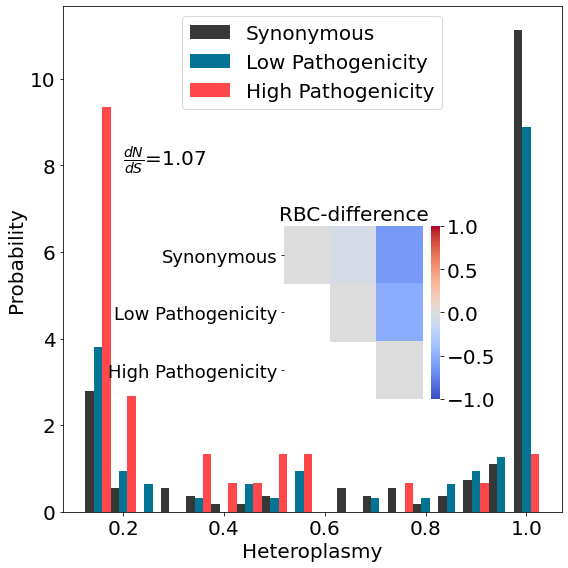

In [ ]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)

fig, ax1 = plt.subplots( figsize=(8, 8))

# Code to get all the data to  plot
bin_arr = [q/20 for q in range(2,21)]
offsets= [0.05/3,0,-0.05/3]
colours=['#363737','#047495','#ff474c']
classes=['Synonymous','Low Pathogenicity','High Pathogenicity']
bars = pd.DataFrame()

# This is just for getting only mutations which are pathology scored.
mas = {'Synonymous':'Synonymous','low_pathogenicity':'Low Pathogenicity','high_pathogenicity':'High Pathogenicity'}
patho_scored = d_donor_all[d_donor_all['MutPred_Probability'] != '.']
patho_scored['MutPred_Prediction'] = patho_scored['MutPred_Prediction'].map(mas)

# Filters for the mutant type, dataset and heteroplasmy range we are interested in
filt = patho_scored = patho_scored[(patho_scored.cells_possible>10)&(patho_scored.dataset =='eng')&(patho_scored.mutant_type != 'Common mutation')&(patho_scored.mutant_type!='Cryptic')&(patho_scored.mean_HF>0.1)].drop_duplicates(subset=['donor_id','POS','ALT'])


# Looks at the class you are interested in, splits up mean heteroplasmy into bins and then counts the number in each bin and normalises
age_dist = {}
for pathology in classes:
    age_dist[pathology] = filt.loc[filt.MutPred_Prediction == pathology].mean_HF
    group = age_dist[pathology].groupby([pd.cut(age_dist[pathology], bin_arr, include_lowest=True)])
    bars[pathology] = group.count()
    bars[pathology] = bars[pathology]/(bars[pathology].sum()*0.05)

# Make dataframe with rank Biserial correlation between each pair of class
stat = []
for pathology in classes:
    kol = []
    for pathology1 in classes:
        kol.append(1-2*stats.mannwhitneyu(age_dist[pathology],age_dist[pathology1],alternative='two-sided')[0]/(len(age_dist[pathology1])*len(age_dist[pathology])))
    stat.append(kol)
biserial = pd.DataFrame(stat,index = classes, columns = classes)
    
    
# Start of Plotting Section:

for i,  age in enumerate(classes):
    ax1.bar(np.array(bin_arr[1:])-offsets[i],bars[age].values,width=-0.05/3,align='center',color=colours[i],label=age)

plt.legend(prop={'size': 20})
plt.xlabel('Heteroplasmy', size = 20)
plt.ylabel('Probability', size = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Annotated with the Non-Synonymous/Synonymous ratio
plt.annotate(r'$\frac{dN}{dS}$'+'={:.2f}'.format(synProp/nonSynProp*nonSynCryp.sum()/synCryp.sum()),xy=(0.2,8),size=20)

left, bottom, width, height = [0.5, 0.3, 0.3, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])

# Plots just the upper triangular of the rank biserial (its just mirrored below and so unimportant)
b = sns.heatmap(biserial.where(np.triu(np.ones(biserial.shape)).astype(np.bool)[0:5,0:5]), cmap='coolwarm', center = 0,vmin=-1,vmax=1, ax=ax2)

b.set_yticklabels(classes, size = 18)
cbar = b.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.title('RBC-difference',size=20)
plt.xticks([])

plt.tight_layout()
plt.savefig('../../figures/publicationFigures/figure2b.pdf')
plt.show()

The below code will generate coverage plots from the files created by our variant calling pipeline. Due to space limitations we are unable to upload these files to GitHub, but they can all be generated using code provided elsewhere in the repository

In [ ]:
cov_all = pd.read_pickle('PATH/TO/COVERAGE')

fig, axs = plt.subplots(3,1,figsize=(1*5, 3*5))

ax=axs.ravel()

position =np.linspace(0,16568,16569)

coverage = np.log10(cov_all.mean(axis=1))
ax[0].plot(position, coverage, color=eng_colour)
ax[0].set_ylim([-4,4])

coverage = cov_all[cov_all>200].count(axis=1)/cov_all.count(axis=1)
ax[1].plot(position, coverage, color=eng_colour)
ax[1].set_ylim([-0.1,1.1])
ax[1].set_title("smartseq2 (Pancreas 1)", size=15)


heteroplasmy = d_donor_all[((d_donor_all.mutant_type!='Common Mutation')&(d_donor_all.cells_possible>10)&(d_donor_all.mean_HF>0.1))].drop_duplicates(subset=['donor_id','POS','ALT']).mean_HF
hetPos = d_donor_all[((d_donor_all.mutant_type!='Common Mutation')&(d_donor_all.cells_possible>10)&(d_donor_all.mean_HF>0.1))].drop_duplicates(subset=['donor_id','POS','ALT']).POS

ax[2].scatter(hetPos, heteroplasmy, color=eng_colour, s=1)


ax[0].set_ylabel('Average depth at base (log$_{10}$)', size = 14)

ax[1].set_ylabel('Proportion of cells passing filters\n (200 reads)', size = 14)

ax[2].set_ylabel('Heteroplasmy', size = 14)

ax[0].set_xlabel('Genome position', size = 14)
ax[1].set_xlabel('Genome position', size = 14)
ax[2].set_xlabel('Genome position', size = 14)

plt.tight_layout()
